In [106]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [107]:
# Constants
# Average weight of an avocado in pounds
AVG_WEIGHT_LB = 0.33

In [182]:
# Reading data
data_pd = pd.read_csv('data/Avocado.csv')

# Cleaning up region names to avoid duplicates
data_pd['region'] = (data_pd['region'].str.replace('/', '')
                                      .str.replace(' ', '')
                                      .str.replace('.', ''))

In [183]:
data_pd[['region', 'AveragePrice']].groupby('region').mean().sort_values(by='AveragePrice')

,AveragePrice
region,
Houston,1.081285
DallasFtWorth,1.097332
SouthCentral,1.124387
PhoenixTucson,1.227925
Nashville,1.229960
Columbus,1.243972
CincinnatiDayton,1.246502
Roanoke,1.260672
NewOrleansMobile,1.264526


# Ideas to explore
- Estimating the price elasticity of demand for avocados
- Demand forecasting
- Apply double machine learning (EconML or CausalML) to perform the above two
- Given external data with unit costs of avocado over the timeframe, can we describe the optimal price and optimize for the future?
- Round number effect?

## Data processing
Thigns to do:
- Date conversion
- Adding cost per pound for financial comparisons later

In [184]:
# Convert date and sort the table by it
data_pd['Date'] = pd.to_datetime(data_pd['Date'])
data_pd = data_pd.sort_values(by='Date', ascending=True)

# Calculate per pound price from piece price
data_pd['avg_price_lb'] = data_pd['AveragePrice'] / AVG_WEIGHT_LB
data_pd['volume_lb'] = data_pd['Total Volume'] * AVG_WEIGHT_LB

In [111]:
# Calculate the PED for each region and organic/regular separately
def calculate_ped(dataframe):

    # Get the percentage difference from row to row in price and volume
    dataframe['delta price[%]'] = dataframe['AveragePrice'].pct_change()
    dataframe['delta volume[%]'] = dataframe['Total Volume'].pct_change()

    # DeltaQ / DeltaP
    ped_series = (dataframe['delta volume[%]'] /
                        dataframe['delta price[%]'])
    
    # Get rid of infinite values to allow average calculation
    ped_series.replace([np.inf, -np.inf], np.nan, inplace=True)

    return ped_series

In [112]:
regions = data_pd['region'].unique()
ped_dict = {}

# Temporarily disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
# For each region, calculate the Price Elasticity of Demand (Volume)
for region in regions:
    data_region_pd = data_pd[data_pd['region'] == region]

    # Calculate for conventional avocado
    data_region_pd['ped_conventional'] = (
        calculate_ped(data_region_pd[data_region_pd['type'] == 'conventional']))
    
    # Calculate for organic avocados
    data_region_pd['ped_organic'] = (
        calculate_ped(data_region_pd[data_region_pd['type'] == 'organic']))
    
    # Get the mean PED value
    ped_conv = data_region_pd['ped_conventional'].mean()
    ped_organic = data_region_pd['ped_organic'].mean()

    # Store values
    ped_dict[region] = {'PED Conventional': ped_conv, 'PED Organic': ped_organic}


# Re-enable warning
pd.options.mode.chained_assignment = 'warn'  # default='warn'

# Convert dict to dataframe
ped_df = pd.DataFrame.from_dict(ped_dict, orient='index').reset_index(names='Region')

In [113]:
collective_regions = ['TotalUS', 'South', 'Southeast', 'Northeast', 'Midsouth', 'NorthernNewEngland', 'SouthCentral', 'West', 'Plains']

# Separate the local values from the collective regions
ped_local_df = ped_df[~ped_df['Region'].isin(collective_regions)]
ped_regional_df = ped_df[ped_df['Region'].isin(collective_regions)]

# Result of basic PED calculation
As seen below we get a realistic result of around -1.5 for the separate regions.

Practically this means a 1.5% decline in volume when the price increases 1%

In [114]:
ped_local_df.drop(columns=['Region']).mean()

PED Conventional   -1.532641
PED Organic        -1.518723
dtype: float64

The collective regions are more noisy for some reason, especially for conventional avocados. I don't have time to look into it, so from now we will just look at the individual regions

In [115]:
ped_regional_df.drop(columns=['Region']).mean()

PED Conventional   -3.234559
PED Organic        -1.418591
dtype: float64

In [116]:
ped_regional_df

,Region,PED Conventional,PED Organic
1,Northeast,6.451289,-2.127297
6,Midsouth,-2.428041,-2.159980
11,NorthernNewEngland,-1.815592,-1.109736
32,Southeast,-5.097503,-1.898865
33,SouthCentral,-1.217190,-1.088508
46,Plains,-1.622128,-1.491515
51,TotalUS,-18.406334,0.444309
53,West,-1.740973,-1.917137


# Applying causal machine learning to estimate price elasticity of demand
We need to divide our data into a few pieces for this.
- Treatment: the average price of avocados
- Outcome: the sales volume
- W, confounders: things that affect both the price and the outcome. E.g. the season, cost of fuel, cost of wheat/flour etc.
- X, 

In [185]:
# Import gasoline data as confounder
gasoline_pd = pd.read_csv('data/gasoline_monthly_usa_FRED.csv')
gasoline_pd['DATE'] = pd.to_datetime(gasoline_pd['DATE'])

In [186]:
# Convert date to year and month
gasoline_pd['year_month'] = (gasoline_pd['DATE'].dt.year.astype(str) + 
                             gasoline_pd['DATE'].dt.month.astype(str))

# Do the same for the avocado data
data_pd['year_month'] = (data_pd['Date'].dt.year.astype(str) + 
                         data_pd['Date'].dt.month.astype(str))

In [187]:
# Join the gas price index based on date to the main df and clean up names
data_pd = (data_pd.merge(gasoline_pd, on='year_month')
                  .rename(columns={'CUUR0000SETB01': 'gas_index'}))

In [132]:
# Sample data for specific region and type for model fitting
model_data_pd = (
    data_pd[(data_pd['region'] == 'NewYork') &
            (data_pd['type'] == 'conventional')]
            [['avg_price_lb', 'volume_lb', 'gas_index', 'year_month']])

In [170]:
from econml.dml import LinearDML
from xgboost import XGBRegressor

In [220]:
# Separate data into outcome, treatment, predictors and confounders
# Using the natural logarithm, so we can assume a linear relationship
# see: LQ = K + E x LP (https://en.wikipedia.org/wiki/Price_elasticity_of_demand)
y = np.log(model_data_pd['volume_lb'])
T = np.log(model_data_pd['avg_price_lb'])
X = model_data_pd[['year_month']].astype(int)
W = model_data_pd[['gas_index']].astype(float)

In [221]:
# Create the estimator using XGBoost regressor as the underlying model
# I'm choosing XGBoost since it's fairly robust out of the box and is a
# tree-based method, so I don't need to do any normalization/scaling of the inputs
est = (LinearDML(
    model_y=XGBRegressor(),
    model_t=XGBRegressor(),
    random_state=42
))
est.fit(y, T, X=X, W=W)


In [222]:
est.const_marginal_effect(X).mean()

-1.6444725975223276

The optimal price per lb is 4.08$


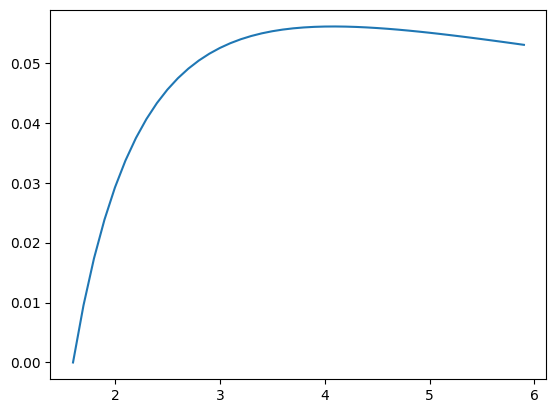

In [269]:
# Optimal price calculation
# Wholesale cost (per lb) from: https://www.indexmundi.com/agricultural-prices/product/avocados
E = est.const_marginal_effect(X).mean()
wholesale_cost = 1.6
opt_price = wholesale_cost / (1 + (1 / E))
print(f'The optimal price per lb is {opt_price:.2f}$')

# Plotting the above
price = np.arange(wholesale_cost, 6, 0.1)
demand = np.exp(est.intercept_ + np.log(price) * E)
profit = (price - wholesale_cost) * demand

plt.plot(price, profit)

In [272]:
price[np.argmax(profit)]

4.100000000000002